In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import pandas as pd

from src.data.dataset import DataLoaderFactory, COVID19Dataset
from src.data.preprocessing import DataAugmentation
from src.models.model import create_model
from src.models.train import Trainer, get_optimizer, get_scheduler, get_criterion

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    torch.cuda.empty_cache()
    print("✅ GPU cache cleared")
else:
    print("⚠️ GPU not available, using CPU")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU Memory: 4.29 GB
✅ GPU cache cleared


In [3]:
# Paths
TRAIN_DIR = '../data/processed/train'
VAL_DIR = '../data/processed/val'
TEST_DIR = '../data/processed/test'
SAVE_DIR = '../models/saved'

# Training parameters (optimized for 4GB GPU)
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

print(f"Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Workers: {NUM_WORKERS}")

Configuration:
  Batch size: 16
  Epochs: 50
  Learning rate: 0.0001
  Workers: 2


In [4]:

print("Creating DataLoaders...")

train_transform = DataAugmentation.get_train_transform()
val_transform = DataAugmentation.get_val_transform()

train_loader, val_loader, test_loader, class_names = DataLoaderFactory.create_dataloaders(
    TRAIN_DIR, VAL_DIR, TEST_DIR,
    train_transform, val_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    use_weighted_sampling=True
)

print(f"\n✅ Classes: {class_names}")
print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Val batches: {len(val_loader)}")

Creating DataLoaders...
Creating datasets...
✅ Loaded 14814 images from 4 classes

Class Distribution in ../data/processed/train:
--------------------------------------------------
  COVID                :  2531 (17.09%)
  Lung_Opacity         :  4208 (28.41%)
  Normal               :  7134 (48.16%)
  Viral Pneumonia      :   941 ( 6.35%)
--------------------------------------------------
✅ Loaded 3175 images from 4 classes

Class Distribution in ../data/processed/val:
--------------------------------------------------
  COVID                :   542 (17.07%)
  Lung_Opacity         :   902 (28.41%)
  Normal               :  1529 (48.16%)
  Viral Pneumonia      :   202 ( 6.36%)
--------------------------------------------------
✅ Loaded 3176 images from 4 classes

Class Distribution in ../data/processed/test:
--------------------------------------------------
  COVID                :   543 (17.10%)
  Lung_Opacity         :   902 (28.40%)
  Normal               :  1529 (48.14%)
  Viral Pn

In [5]:
train_dataset = COVID19Dataset(TRAIN_DIR, transform=train_transform)
class_weights = train_dataset.get_class_weights()

print(f"\nClass weights:")
for cls, weight in zip(class_names, class_weights):
    print(f"  {cls:20} : {weight:.4f}")

✅ Loaded 14814 images from 4 classes

Class Distribution in ../data/processed/train:
--------------------------------------------------
  COVID                :  2531 (17.09%)
  Lung_Opacity         :  4208 (28.41%)
  Normal               :  7134 (48.16%)
  Viral Pneumonia      :   941 ( 6.35%)
--------------------------------------------------

Class weights:
  COVID                : 1.4633
  Lung_Opacity         : 0.8801
  Normal               : 0.5191
  Viral Pneumonia      : 3.9357


In [6]:
def train_model(model_name, num_epochs=NUM_EPOCHS, lr=LEARNING_RATE):
    """Train a single model"""
    print("\n" + "="*70)
    print(f"TRAINING {model_name.upper()}")
    print("="*70)
    
    torch.cuda.empty_cache()
    
    # Create model
    model = create_model(model_name, num_classes=len(class_names), pretrained=(model_name != 'baseline'))
    model = model.to(device)
    
    # Model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nParameters: {total_params:,} total, {trainable_params:,} trainable")
    
    # GPU memory
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.3f} GB allocated")
    
    # Setup
    criterion = get_criterion(class_weights, device)
    optimizer = get_optimizer(model, optimizer_name='adam', lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = get_scheduler(optimizer, scheduler_name='plateau', patience=5, factor=0.5)
    
    # Train
    trainer = Trainer(
        model=model, train_loader=train_loader, val_loader=val_loader,
        criterion=criterion, optimizer=optimizer, scheduler=scheduler,
        device=device, num_epochs=num_epochs, save_dir=SAVE_DIR,
        model_name=model_name, early_stopping_patience=10
    )
    
    start = time.time()
    history = trainer.train()
    elapsed = time.time() - start
    
    print(f"\n✅ Training completed in {elapsed/60:.2f} minutes")
    
    # Cleanup
    del model, trainer, optimizer, scheduler
    torch.cuda.empty_cache()
    
    return history

In [7]:
def plot_model_results(history, model_name):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Training Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title(f'{model_name} - Training Loss', fontsize=13, fontweight='bold')
    axes[0, 0].grid(alpha=0.3)
    
    # Validation Loss
    axes[0, 1].plot(epochs, history['val_loss'], 'r-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Loss', fontsize=11)
    axes[0, 1].set_title(f'{model_name} - Validation Loss', fontsize=13, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # Training Accuracy
    axes[1, 0].plot(epochs, history['train_acc'], 'b-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 0].set_title(f'{model_name} - Training Accuracy', fontsize=13, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # Validation Accuracy
    axes[1, 1].plot(epochs, history['val_acc'], 'r-', linewidth=2)
    best_acc = max(history['val_acc'])
    axes[1, 1].axhline(y=best_acc, color='g', linestyle='--', label=f'Best: {best_acc:.2f}%')
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[1, 1].set_title(f'{model_name} - Validation Accuracy', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../results/plots/{model_name}_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print(f"\n{'='*70}")
    print(f"{model_name.upper()} RESULTS")
    print('='*70)
    print(f"Best Val Accuracy: {best_acc:.2f}% (Epoch {history['val_acc'].index(best_acc) + 1})")
    print(f"Final Train Acc: {history['train_acc'][-1]:.2f}%")
    print(f"Final Val Acc: {history['val_acc'][-1]:.2f}%")
    print('='*70)

🚀 TRAINING RESNET50 (PRIMARY MODEL)
Expected time: ~30-40 minutes
This model typically achieves 92-96% accuracy

Starting training...


TRAINING RESNET50
  Using ImageNet pretrained weights
✅ Built resnet50 with 4 output classes

Parameters: 24,691,012 total, 24,691,012 trainable
GPU Memory: 0.099 GB allocated
✅ Trainer initialized
   Device: cuda
   Epochs: 50
   Save directory: ../models/saved

STARTING TRAINING

Epoch 1/50
----------------------------------------------------------------------


Train Loss: 0.4248 | Train Acc: 72.37%
Val Loss:   0.5532 | Val Acc:   75.46%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 75.46%)

Epoch 2/50
----------------------------------------------------------------------


Train Loss: 0.2387 | Train Acc: 84.02%
Val Loss:   0.3884 | Val Acc:   85.20%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 85.20%)

Epoch 3/50
----------------------------------------------------------------------


Train Loss: 0.1877 | Train Acc: 87.36%
Val Loss:   0.2393 | Val Acc:   92.00%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 92.00%)

Epoch 4/50
----------------------------------------------------------------------


Train Loss: 0.1665 | Train Acc: 88.64%
Val Loss:   0.2324 | Val Acc:   91.72%
Learning Rate: 0.000100

Epoch 5/50
----------------------------------------------------------------------


Train Loss: 0.1520 | Train Acc: 89.33%
Val Loss:   0.3320 | Val Acc:   86.93%
Learning Rate: 0.000100

Epoch 6/50
----------------------------------------------------------------------


Train Loss: 0.1495 | Train Acc: 90.00%
Val Loss:   0.2294 | Val Acc:   91.12%
Learning Rate: 0.000100

Epoch 7/50
----------------------------------------------------------------------


Train Loss: 0.1364 | Train Acc: 90.92%
Val Loss:   0.2600 | Val Acc:   90.30%
Learning Rate: 0.000100

Epoch 8/50
----------------------------------------------------------------------


Train Loss: 0.1286 | Train Acc: 91.35%
Val Loss:   0.2181 | Val Acc:   92.38%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 92.38%)

Epoch 9/50
----------------------------------------------------------------------


Train Loss: 0.1221 | Train Acc: 91.71%
Val Loss:   0.2127 | Val Acc:   92.82%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 92.82%)

Epoch 10/50
----------------------------------------------------------------------


Train Loss: 0.1184 | Train Acc: 92.20%
Val Loss:   0.2017 | Val Acc:   92.72%
Learning Rate: 0.000100

Epoch 11/50
----------------------------------------------------------------------


Train Loss: 0.1090 | Train Acc: 92.47%
Val Loss:   0.2176 | Val Acc:   92.13%
Learning Rate: 0.000100

Epoch 12/50
----------------------------------------------------------------------


Train Loss: 0.1145 | Train Acc: 92.48%
Val Loss:   0.1922 | Val Acc:   93.04%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 93.04%)

Epoch 13/50
----------------------------------------------------------------------


Train Loss: 0.1065 | Train Acc: 92.70%
Val Loss:   0.2604 | Val Acc:   91.72%
Learning Rate: 0.000100

Epoch 14/50
----------------------------------------------------------------------


Train Loss: 0.1073 | Train Acc: 92.54%
Val Loss:   0.1636 | Val Acc:   94.36%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 94.36%)

Epoch 15/50
----------------------------------------------------------------------


Train Loss: 0.0921 | Train Acc: 93.60%
Val Loss:   0.2090 | Val Acc:   93.01%
Learning Rate: 0.000100

Epoch 16/50
----------------------------------------------------------------------


Train Loss: 0.0910 | Train Acc: 93.65%
Val Loss:   0.1769 | Val Acc:   93.80%
Learning Rate: 0.000100

Epoch 17/50
----------------------------------------------------------------------


Train Loss: 0.0890 | Train Acc: 94.03%
Val Loss:   0.1673 | Val Acc:   94.05%
Learning Rate: 0.000100

Epoch 18/50
----------------------------------------------------------------------


Train Loss: 0.0908 | Train Acc: 93.78%
Val Loss:   0.1959 | Val Acc:   93.13%
Learning Rate: 0.000100

Epoch 19/50
----------------------------------------------------------------------


Train Loss: 0.0845 | Train Acc: 94.21%
Val Loss:   0.1851 | Val Acc:   93.32%
Learning Rate: 0.000100

Epoch 20/50
----------------------------------------------------------------------


Train Loss: 0.0789 | Train Acc: 94.42%
Val Loss:   0.1627 | Val Acc:   94.43%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 94.43%)

Epoch 21/50
----------------------------------------------------------------------


Train Loss: 0.0878 | Train Acc: 94.17%
Val Loss:   0.1468 | Val Acc:   94.96%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 94.96%)

Epoch 22/50
----------------------------------------------------------------------


Train Loss: 0.0827 | Train Acc: 94.31%
Val Loss:   0.1326 | Val Acc:   95.62%
Learning Rate: 0.000100
   💾 Saved best model (val_acc: 95.62%)

Epoch 23/50
----------------------------------------------------------------------


Train Loss: 0.0798 | Train Acc: 94.32%
Val Loss:   0.1419 | Val Acc:   95.46%
Learning Rate: 0.000100

Epoch 24/50
----------------------------------------------------------------------


Train Loss: 0.0824 | Train Acc: 94.36%
Val Loss:   0.1771 | Val Acc:   93.89%
Learning Rate: 0.000100

Epoch 25/50
----------------------------------------------------------------------


Train Loss: 0.0763 | Train Acc: 94.82%
Val Loss:   0.1728 | Val Acc:   93.86%
Learning Rate: 0.000100

Epoch 26/50
----------------------------------------------------------------------


Train Loss: 0.0776 | Train Acc: 94.53%
Val Loss:   0.3488 | Val Acc:   87.06%
Learning Rate: 0.000100

Epoch 27/50
----------------------------------------------------------------------


Train Loss: 0.0798 | Train Acc: 94.61%
Val Loss:   0.1704 | Val Acc:   93.89%
Learning Rate: 0.000100

Epoch 28/50
----------------------------------------------------------------------


Train Loss: 0.0719 | Train Acc: 94.73%
Val Loss:   0.1480 | Val Acc:   94.65%
Learning Rate: 0.000100

Epoch 29/50
----------------------------------------------------------------------


Train Loss: 0.0551 | Train Acc: 96.19%
Val Loss:   0.1171 | Val Acc:   96.13%
Learning Rate: 0.000050
   💾 Saved best model (val_acc: 96.13%)

Epoch 30/50
----------------------------------------------------------------------


Train Loss: 0.0541 | Train Acc: 96.25%
Val Loss:   0.1219 | Val Acc:   95.87%
Learning Rate: 0.000050

Epoch 31/50
----------------------------------------------------------------------


Train Loss: 0.0519 | Train Acc: 96.15%
Val Loss:   0.1375 | Val Acc:   95.06%
Learning Rate: 0.000050

Epoch 32/50
----------------------------------------------------------------------


Train Loss: 0.0491 | Train Acc: 96.46%
Val Loss:   0.1232 | Val Acc:   95.65%
Learning Rate: 0.000050

Epoch 33/50
----------------------------------------------------------------------


Train Loss: 0.0457 | Train Acc: 96.92%
Val Loss:   0.1178 | Val Acc:   95.91%
Learning Rate: 0.000050

Epoch 34/50
----------------------------------------------------------------------


Train Loss: 0.0515 | Train Acc: 96.46%
Val Loss:   0.1300 | Val Acc:   95.43%
Learning Rate: 0.000050

Epoch 35/50
----------------------------------------------------------------------


Train Loss: 0.0450 | Train Acc: 96.94%
Val Loss:   0.1250 | Val Acc:   95.75%
Learning Rate: 0.000050

Epoch 36/50
----------------------------------------------------------------------


Train Loss: 0.0394 | Train Acc: 97.05%
Val Loss:   0.1116 | Val Acc:   95.97%
Learning Rate: 0.000025

Epoch 37/50
----------------------------------------------------------------------


Train Loss: 0.0376 | Train Acc: 97.28%
Val Loss:   0.1104 | Val Acc:   96.06%
Learning Rate: 0.000025

Epoch 38/50
----------------------------------------------------------------------


Train Loss: 0.0340 | Train Acc: 97.52%
Val Loss:   0.1128 | Val Acc:   95.75%
Learning Rate: 0.000025

Epoch 39/50
----------------------------------------------------------------------


Train Loss: 0.0307 | Train Acc: 97.63%
Val Loss:   0.1325 | Val Acc:   95.40%
Learning Rate: 0.000025

⚠️ Early stopping triggered after 39 epochs
   No improvement for 10 epochs

TRAINING COMPLETE
Total time: 108.98 minutes
Best validation accuracy: 96.13% (epoch 29)
✅ Training history saved to: ..\models\saved\resnet50_history.json

✅ Training completed in 108.98 minutes


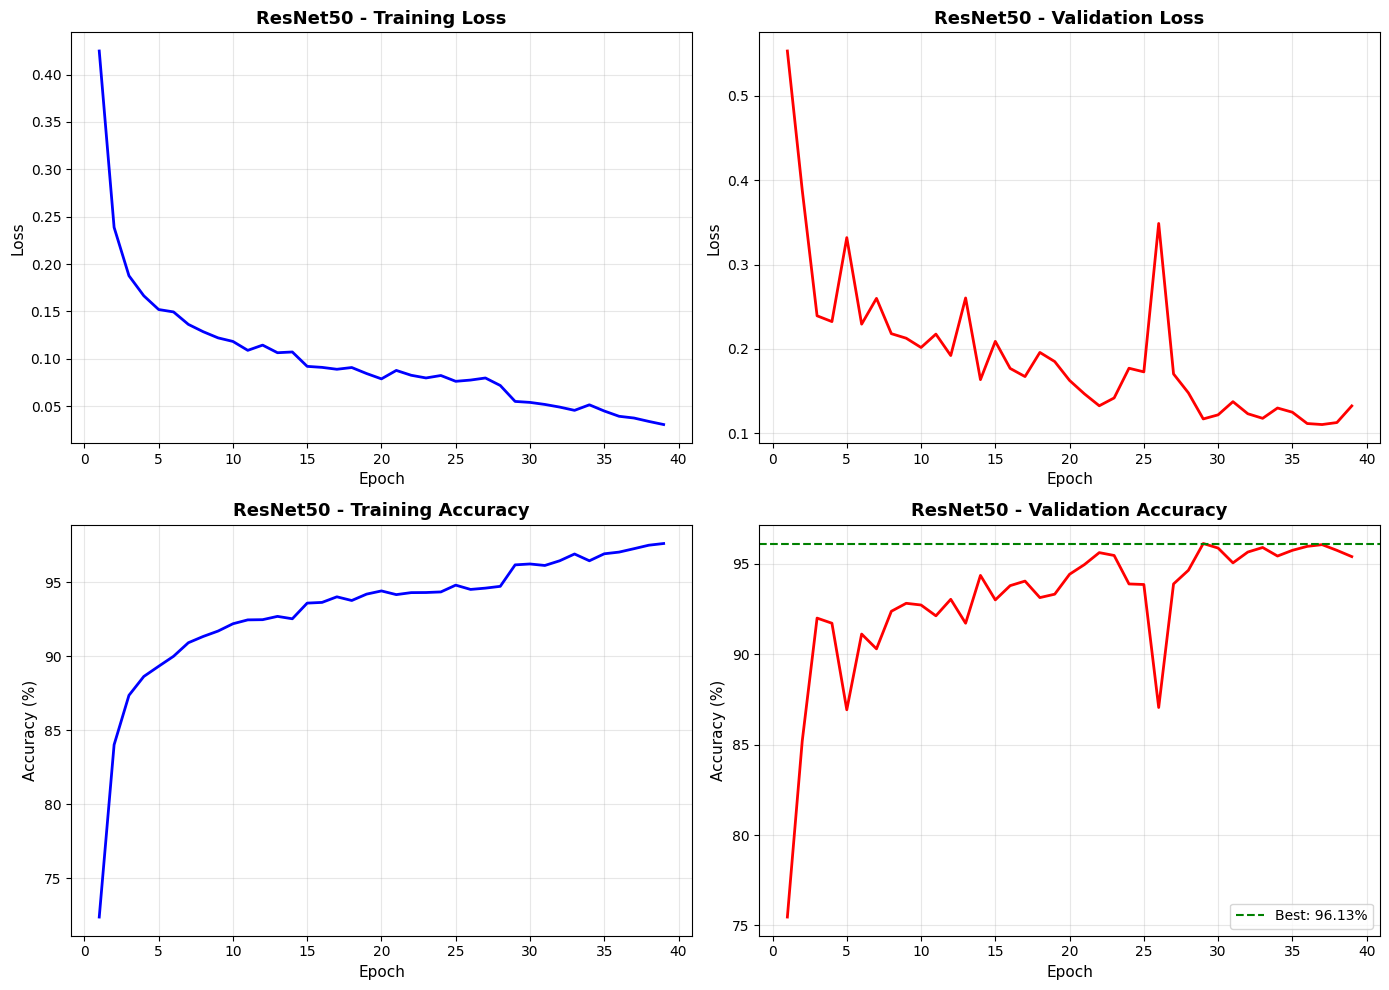


RESNET50 RESULTS
Best Val Accuracy: 96.13% (Epoch 29)
Final Train Acc: 97.63%
Final Val Acc: 95.40%


In [8]:
print("🚀 TRAINING RESNET50 (PRIMARY MODEL)")
print("Expected time: ~30-40 minutes")
print("This model typically achieves 92-96% accuracy")
print("\nStarting training...\n")

resnet_history = train_model('resnet50', num_epochs=NUM_EPOCHS, lr=0.0001)
plot_model_results(resnet_history, 'ResNet50')